# VLSI - SMT Part
Di Tuccio Gianluca, Orsini Lorenzo

In [1]:
from tqdm import tqdm
from z3 import *
from numpy import random
import os
import pandas as pd



'''
SET HERE THE PATH OF THE MAIN FOLDER (i.e VLSI folder)
            |
            |
            V
'''
os.chdir('/Users/gianlucadituccio/Documents/VLSI')
from utils.utils import *

## SMT without Rotation

In [ ]:
def SMT(parameters, height, timeout=300):
    try:
        # declaration the variables for the current instance
        w = parameters['w']
        n = parameters['n_rectangles']
        solver = Optimize()  
        
        # start the timer of the execution
        # the time for constraints is inglobed inside the timeout
        t_constraint = time.process_time()
        if t_constraint>timeout*1000: return {}
        
        # declaration of the plate (i.e. all possible coordinates)
        # in this case we've used INT array instead a BOOL matrix
        px = [Int(f"px_{i+1}") for i in range(n)]
        py = [Int(f"py_{i+1}") for i in range(n)]

        # declaration of the left-right rectangles positions
        lr = [[Bool(f"lr_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        
        # sort rectangles by y component
        rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
        sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
        x_components = [k[0] for k in sorted_rectangles]
        y_components = [k[1] for k in sorted_rectangles]
        original_indices = [k[2] for k in sorted_rectangles]
        
        h_min = parameters['min_h']
        h_max = sum(y_components)
        
        h = Int('height')
        solver.add(h>=h_min)
        solver.add(h<=h_max)
        
        solver.add(px[0]==0)
        solver.add(py[0]==0)
        
        for i in range(n):
            
            # some useful constraint for position and component
            solver.add(px[i]+x_components[i]<=w)
            solver.add(py[i]+y_components[i]<=h)
            solver.add(px[i]>=0)
            solver.add(py[i]>=0)
        
            # no overlap constraints
            for j in range(i+1, n):
                solver.add((px[i]+x_components[i] <= px[j]) == lr[i][j])
                solver.add((py[i]+y_components[i] <= py[j]) == ud[i][j])
                solver.add((px[j]+x_components[j] <= px[i]) == lr[j][i])
                solver.add((py[j]+y_components[j] <= py[i]) == ud[j][i])
                solver.add(Sum(If(lr[i][j],1,0), If(lr[j][i],1,0), If(ud[i][j],1,0), If(ud[j][i],1,0))>=1)
            if t_constraint>timeout*1000: return {}
            
            # some reductions (proposed in the SAT PAPER)
            for j in range(n):
                if i!=j:
                    # large rectangles constraint (PAPER)
                    solver.add(If(x_components[i]+x_components[j]>w, lr[i][j] == False and lr[j][i] == False, True))
                    solver.add(If(y_components[i]+y_components[j]>h, ud[i][j] == False and ud[j][i] == False, True))
                    
                    # same rectangles constraint (PAPER)
                    solver.add(If(x_components[i]==x_components[j] and y_components[i]==y_components[j], 
                                  lr[j][i]==False and (lr[i][j] or ud[j][i]), True))
                
            if t_constraint>timeout*1000: return {}
            
        solver.set("timeout", timeout*1000-int(t_constraint))
        solver.minimize(h)
        
        if solver.check() == sat:
            solution = solver.model()
            
            output = {}
            output['h'] = solution.evaluate(h).as_long()  
            output['W'] = w
            
            x_positions = []
            for i in px:
                x_positions.append(solution.evaluate(i).as_long())
            
            y_positions = []
            for i in py:
                y_positions.append(solution.evaluate(i).as_long())
                
            # re-take the original order of the rectangles
            positions = [(x, y, i, z, k) for x, y, i, z, k in zip(x_positions, y_positions, x_components, y_components, original_indices)]
            x_positions, y_positions, x_components, y_components, _ = zip(*sorted(positions, key=lambda x: x[4]))
            
            output['x_positions'] = x_positions
            output['y_positions'] = y_positions
            output['x_components'] = x_components
            output['y_components'] = y_components
            
            return output
        return {}
        
    except Exception as ex: print(ex)

In [ ]:
for i in tqdm(range(1,41)):
    file = LoadInstance('utils/instances/',f'ins-{i}.txt')
    t0 = time.time()
    
    result = SMT(parameters=file, height=file['min_h'], timeout=300)
    t1 = time.time()
    time_computation = t1-t0
    if result:
        # if you want plot the results without saving them, use: PlotInstance(result)
        PlotInstance(result, 
                     path='SMT/images', 
                     name='fig-'+str(i))
        WriteInstance(result,
                     path='SMT/out',
                     name='out-'+str(i))
    else:
        print('Instance', i, 'TIMEOUT')

## SMT with Rotation

In [ ]:
def SMTRotation(parameters, height, timeout=300):
    try:
        # declaration the variables for the current instance
        w = parameters['w']
        n = parameters['n_rectangles']
        solver = Optimize()
        
        
        # start the timer of the execution
        # the time for constraints is inglobed inside the timeout
        t_constraint = time.process_time()
        if t_constraint>timeout*1000: return {}
        
        # declaration of the plate (i.e. all possible coordinates)
        # first index --> rectangle; second index --> coordinates from 0 to w
        px = [Int(f"px_{i+1}") for i in range(n)]
        
        # first index --> rectangle; second index --> coordinates from 0 to height
        py = [Int(f"py_{i+1}") for i in range(n)]

        # declaration of the left-right rectangles positions
        lr = [[Bool(f"lr_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        
        # rotation
        rot = [Bool(f"rot_{i+1}") for i in range(n)]
        
        # sort rectangles by y component
        rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
        sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
        x_components = [k[0] for k in sorted_rectangles]
        y_components = [k[1] for k in sorted_rectangles]
        original_indices = [k[2] for k in sorted_rectangles] 
        
        x_components_rotated = [Int(f"x_comp_rot_{i+1}") for i in range(n)]
        y_components_rotated = [Int(f"y_comp_rot_{i+1}") for i in range(n)]
        
        h_min = parameters['min_h']
        h_max = sum(y_components)
        
        h = Int('height')
        solver.add(h>=h_min)
        solver.add(h<=h_max)
        
        solver.add(px[0]==0)
        solver.add(py[0]==0)
        
        
        for i in range(n):
            solver.add(If(y_components[i]>w, rot[i]==False, True))
            solver.add(If(x_components[i]>h, rot[i]==False, True))
            
            solver.add(Or(x_components_rotated[i]==y_components[i], x_components_rotated[i]==x_components[i]))
            solver.add(Or(y_components_rotated[i]==y_components[i], y_components_rotated[i]==x_components[i]))
            
            
            solver.add(px[i]+x_components_rotated[i]<=w)
            solver.add(py[i]+y_components_rotated[i]<=h)
            solver.add(px[i]>=0)
            solver.add(py[i]>=0)
            if t_constraint>timeout*1000: return {}
            
            solver.add(If(x_components[i]==y_components[i], rot[i]==False, True))
           
            # rotation
            solver.add(If(rot[i], x_components_rotated[i]==y_components[i], x_components_rotated[i]==x_components[i]))
            solver.add(If(rot[i], y_components_rotated[i]==x_components[i], y_components_rotated[i]==y_components[i]))             
            
            # Non overlapping constraints
            for j in range(i+1, n):
                
                solver.add((px[i]+x_components_rotated[i] <= px[j]) == lr[i][j])
                solver.add((py[i]+y_components_rotated[i] <= py[j]) == ud[i][j])
                solver.add((px[j]+x_components_rotated[j] <= px[i]) == lr[j][i])
                solver.add((py[j]+y_components_rotated[j] <= py[i]) == ud[j][i])
                solver.add(Sum(If(lr[i][j],1,0), If(lr[j][i],1,0), If(ud[i][j],1,0), If(ud[j][i],1,0))>=1)
            
            for j in range(n):
                if i!=j:
                    solver.add(If(x_components_rotated[i]+x_components_rotated[j]>w, lr[i][j] == False and lr[j][i] == False, True))
                    solver.add(If(y_components_rotated[i]+y_components_rotated[j]>h, ud[i][j] == False and ud[j][i] == False, True))
    
            if t_constraint>timeout*1000: return {}
            
        solver.set("timeout", timeout*1000-int(t_constraint))
        solver.minimize(h)
        if solver.check() == sat:
            solution = solver.model()
            output = {}
            output['h'] = solution.evaluate(h).as_long()  
            output['W'] = w
            
            x_positions = []
            for i in px:
                x_positions.append(solution.evaluate(i).as_long())
            
            y_positions = []
            for i in py:
                y_positions.append(solution.evaluate(i).as_long())
            
            rota = [False if str(solution.evaluate(rot[index]))=='False' else True for index in range(n)]
            tmp1 = [y_components[i] if rota[i] else x_components[i] for i in range(len(x_components))]
            y_components = [x_components[i] if rota[i] else y_components[i] for i in range(len(y_components))]
            x_components = tmp1
            
            output['x_positions'] = x_positions
            output['y_positions'] = y_positions
            output['x_components'] = x_components
            output['y_components'] = y_components
            output['rotation'] = rota
            return output
        return {}
        
    except Exception as ex: print(ex)

In [ ]:
for i in tqdm(range(1,41)):
    file = LoadInstance('utils/instances/',f'ins-{i}.txt')
    t0 = time.time()
    result = SMTRotation(parameters=file, height=file['min_h'], timeout=300)
    t1 = time.time()
    time_computation = t1-t0
    if result and time_computation<300:
        # if you want plot the results without saving them, use: PlotInstance(result)
        PlotInstance(result, 
                     path='SMT/images', 
                     name='rotation_fig-'+str(i))
        WriteInstance(result,
                     path='SMT/out',
                     name='rotation_out-'+str(i))
    else:
        print('Instance', i, 'TIMEOUT')

In [2]:
rotation = pd.read_csv('utils/datasets/SMT.csv')
Statistics({'No Rotation':rotation['time'], 
            'Rotation':rotation['time_rotation']}, 
           {'h_min':rotation['h_min'], 
            'No Rotation':rotation['h'], 
            'Rotation':rotation['h_rotation']},
            timeout=300)

TIMEOUT is seen as 300s.

+------------------+-------------+----------+
|                  | No Rotation | Rotation |
+------------------+-------------+----------+
|  Total Time [s]  |    2472.513 | 6000.952 |
|     Max [s]      |       300.0 |    300.0 |
|     Min [s]      |       0.026 |    0.042 |
|     Mean [s]     |      61.813 |  150.024 |
|     Std [s]      |      96.325 |  129.653 |
| Instances Solved |       36/40 |    28/40 |
|    Optimal H     |       36/40 |    28/40 |
+------------------+-------------+----------+


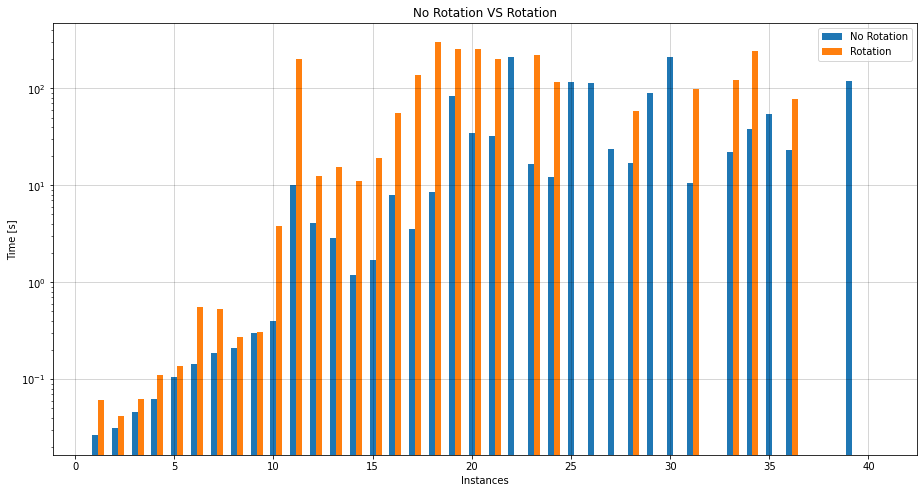

In [3]:
PlotStats({'No Rotation':rotation['time'], 
            'Rotation':rotation['time_rotation']},
            x_axis=list(rotation['Instance']))